In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "04_02_2025",
                'genotype_dir': 'EPG_jGCaMP7f_OctB1RRNAi/control',
                'fly': 'fly2',
                'session': 'closed_loop-002',
                'fictrac_scan_num':2,
                'fictrac_dat_file' : 'fictrac-20250204_091607.dat',
                'full_genotype': '',
                'ecl date': '',
                'notes': ''}


session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly3_1_scan0.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'],
                                         # fictrac_pkl_path=pkl_path,
                                        )



In [3]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    # y_r4d = pp.timeseries['rois_R4d_z']
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]

In [4]:
pp.extract_metadata()

pp.align_voltage_recording()


In [5]:
pp.align_fictrac()

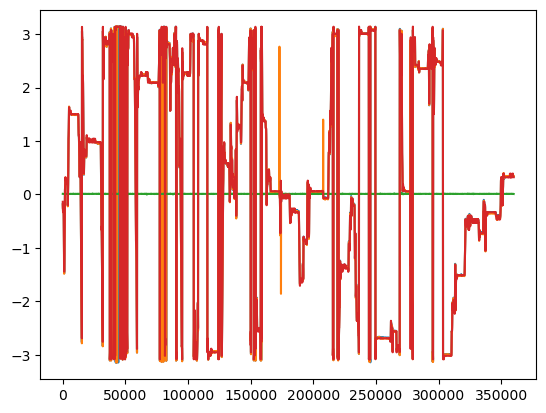

In [6]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [7]:
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [8]:
print()

In [9]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [10]:
# y = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = False)-1
# y = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)-1
y = pp.calculate_zscored_F('rois', zscore=True, exp_detrend = True)
# y = y  - pp.timeseries['background']

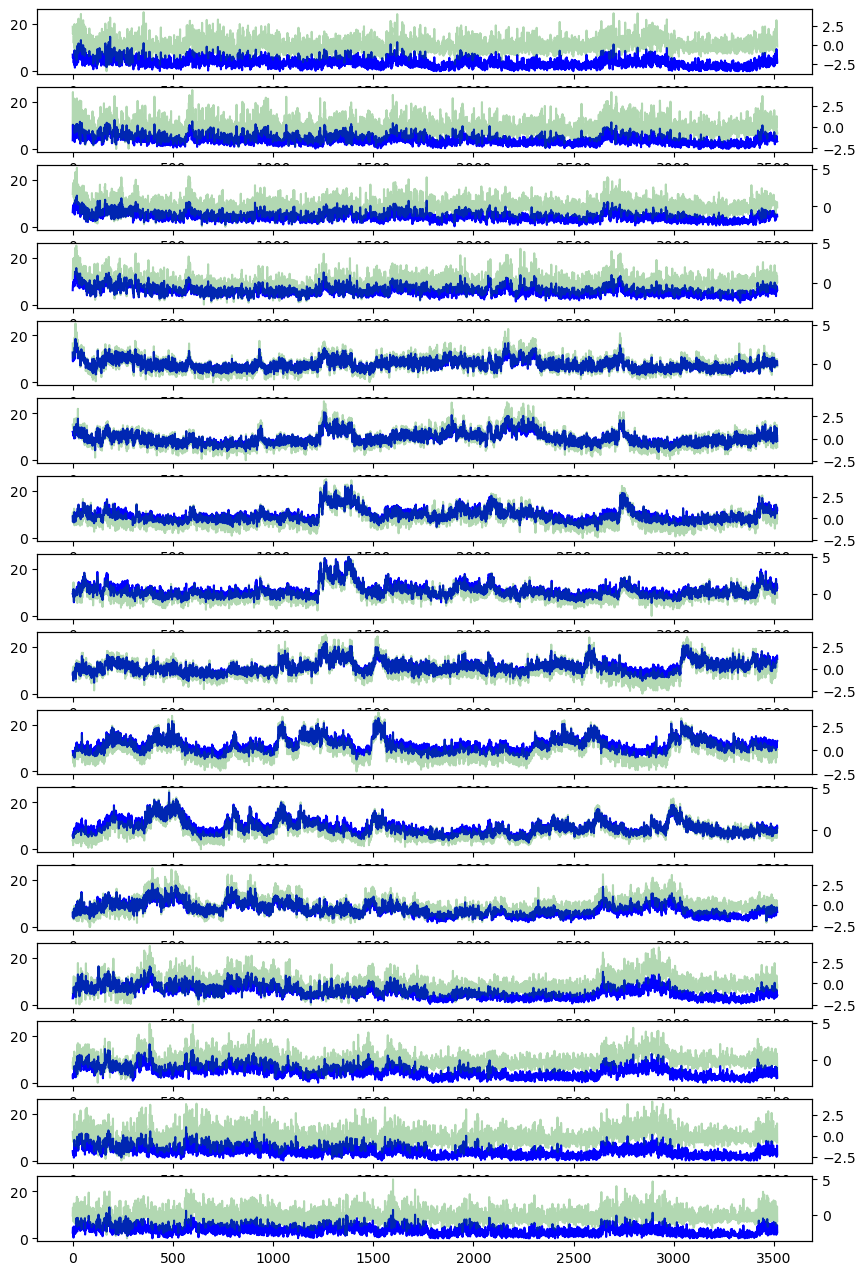

In [11]:
fig,ax = plt.subplots(16,1, figsize=[10,16],sharey=True)
for r in range(n_rois):
    ax[r].plot(pp.timeseries['rois'][-1,r,:], color='blue')
    axx = ax[r].twinx()
    axx.plot(y[-1,r,:], color='green', alpha=.3)


In [12]:
pp.save()

In [13]:
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y, 2, axis=-1),.7,axis=1, mode='wrap')
y_sm_dm = sp.stats.zscore(y,axis=1)
# y_sm = y-1  #sp.ndimage.gaussian_filter1d(y, 1, axis=-1)

x_f,y_f = st2p.utilities.pol2cart(y_sm[-1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
# x_f,y_f = st2p.utilities.pol2cart(y_sm_dm[-1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(3518,) (3518,)


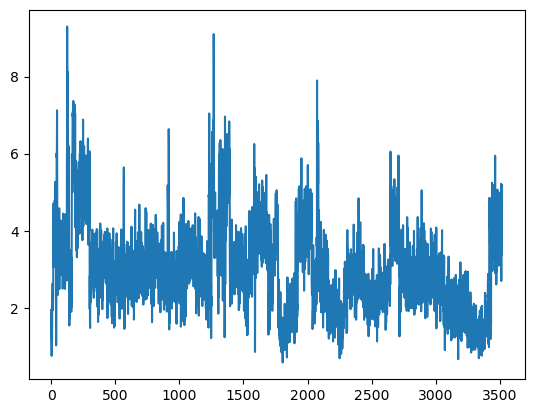

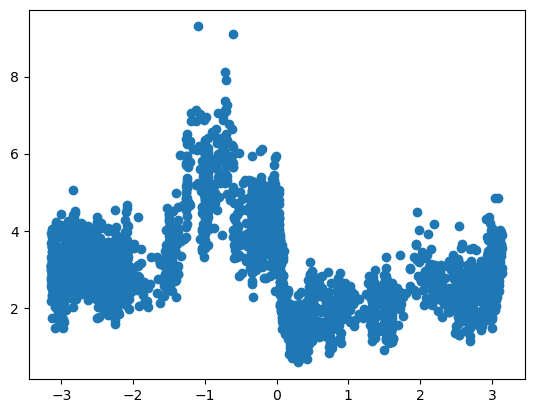

In [14]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][-1,0,:])
fig, ax= plt.subplots()
ax.scatter(heading, pp.timeseries['background'][-1,0,:])

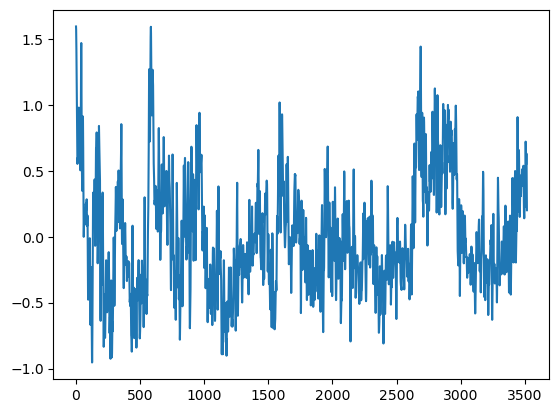

In [15]:
fig,ax = plt.subplots()
ax.plot(y_sm[-1,0,:])

Text(0.5, 1.0, '0.5212013040267807')

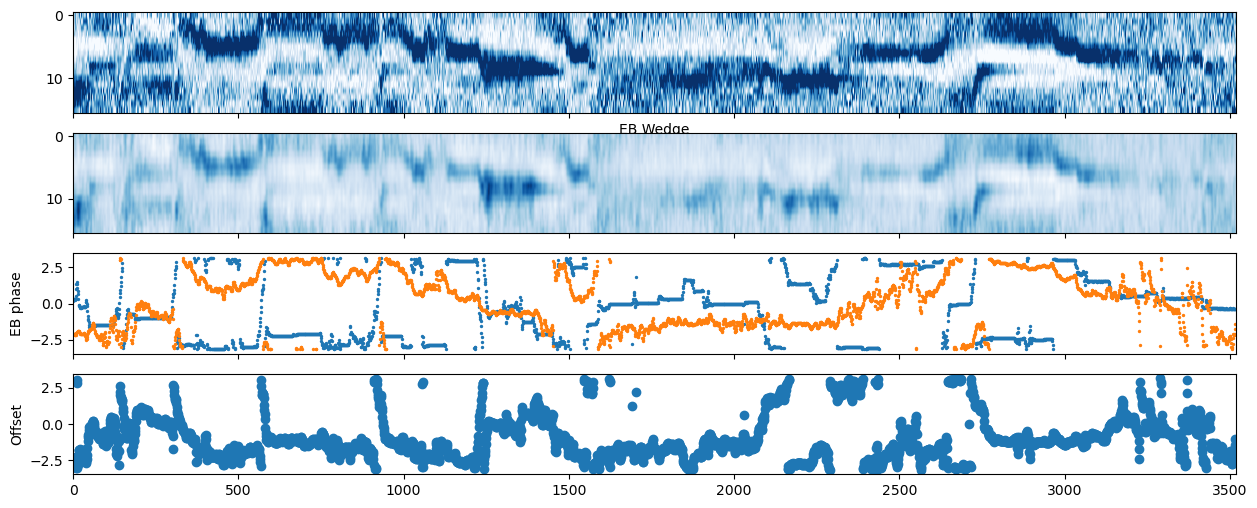

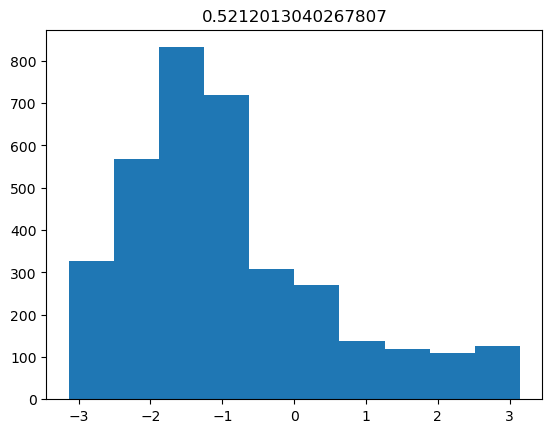

In [16]:
fig, ax= plt.subplots(4,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm_dm[-1,::-1,:], aspect='auto', cmap= 'Blues', vmin=-1,vmax=1)#, vmin=-1,vmax=1)
ax[1].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues')#, vmin=-.1,vmax=.8)#, vmin=-1,vmax=1)
# ax[0].imshow(y_sm_dm[-1,::-1,:], aspect='auto', cmap= 'Blues') #, vmin=-1,vmax=1)#, vmin=-1,vmax=1)
# ax[0].scatter(np.arange(y.shape[-1]), 15*(heading+np.pi)/2/np.pi)
ax[0].set_xlabel('EB Wedge')


# print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
# print(y.shape, heading.shape)
ax[2].scatter(x[:]-x[0],heading[:], s=2)
ax[2].scatter(x[:]-x[0], phi[:], s=2)
ax[2].set_ylabel('EB phase')
ax[3].scatter(x[:]-x[0], offset[:])
ax[3].set_ylabel('Offset')
# fig.savefig('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/hm4d_pilot.pdf')
dh = np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0)))
mask = ((heading>.5) | (heading<-.5) ) #& (dh <.1)
fig, ax= plt.subplots()
ax.hist(offset)
ax.set_title(sp.stats.circvar(offset))

(16,) (16,)


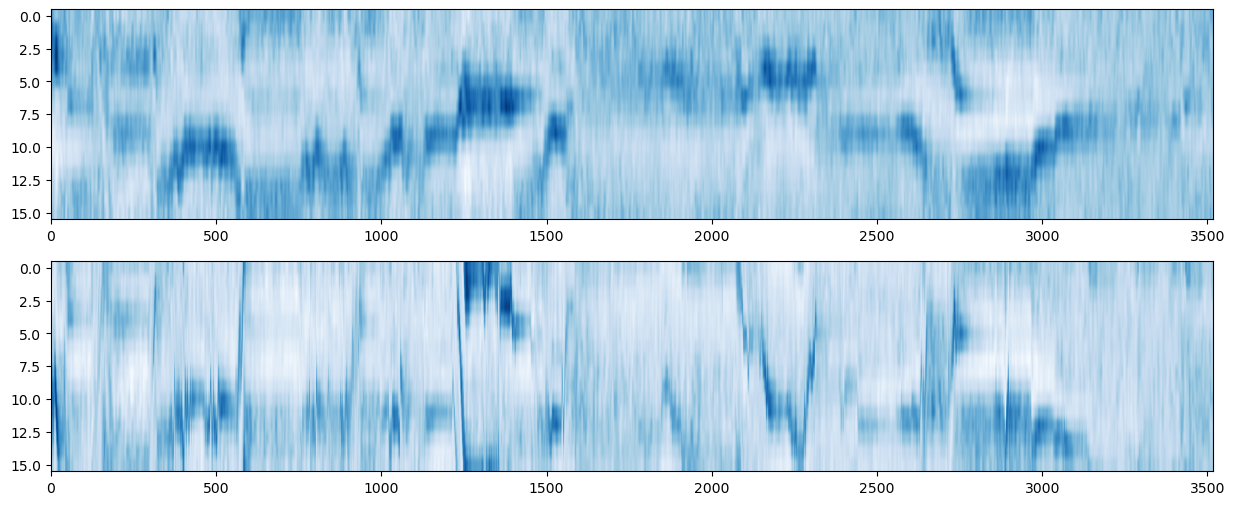

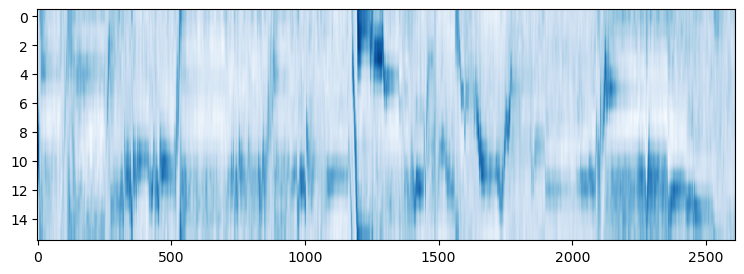

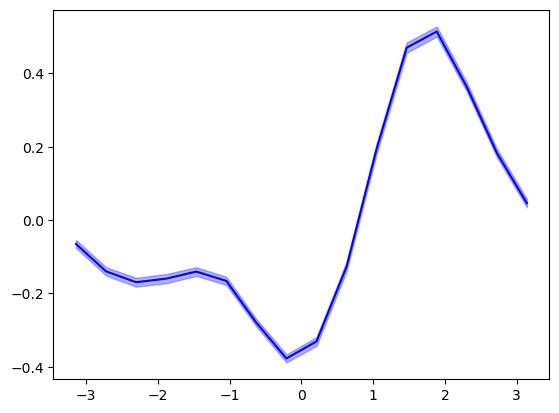

In [17]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[-1,:,ind] = np.roll(y_sm[-1,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
# ax[0].imshow(y_sm[-1,:, :] , cmap='Blues',aspect='auto') #',vmin=-.1,vmax=.3)
ax[1].imshow(y_sm_heading_aligned[-1,:,:], cmap='Blues',aspect='auto')#,vmin=-.1,vmax=.3)
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
# ax[1].imshow(y_sm_heading_aligned[0,:,:] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,mask].mean(axis=-1)[-1,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask], axis=-1)[-1,:]
print(mu.shape, sem.shape)
fig, ax = plt.subplots(figsize=[9,3])
ax.imshow(y_sm_heading_aligned[:,:,mask][-1,:,:], cmap='Blues', aspect='auto')#, vmin=-.3, vmax=.1)

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [ ]:
print(sp.stats.circvar(offset[mask]))

0.12604437416083636 1.2524837040880465e-05
0.30424665373217 1.3593954720560405e-74
[-0.75452549  0.00979122  0.0312602   0.05211213  0.07119439  0.09226987
  0.11174724  0.1326279   0.15319088  0.17222478  0.19416953  0.21425903
  0.23552274  0.25422746  0.27424525  0.29357448  0.31549121  0.33863875
  0.35692628  0.37866218  0.39725813  0.4183926   0.43945467  0.45784609
  0.47770001  0.50063627  0.52099038  0.53908692  0.56139656  0.58259666
  0.6029272   0.62132984  0.64236915  0.6624227   0.68255072  0.7043063
  0.7254234   0.74581687  0.76533639  0.78375527  0.80828688  0.82465168
  0.84703368  0.86643476  0.88915873  0.90920649  0.92751233  0.94936392
  0.9714109   0.98902337  1.64744763]


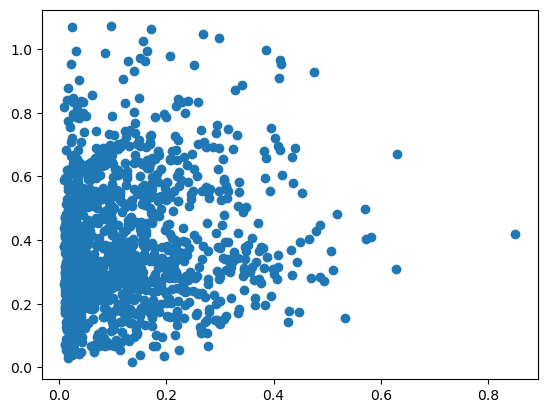

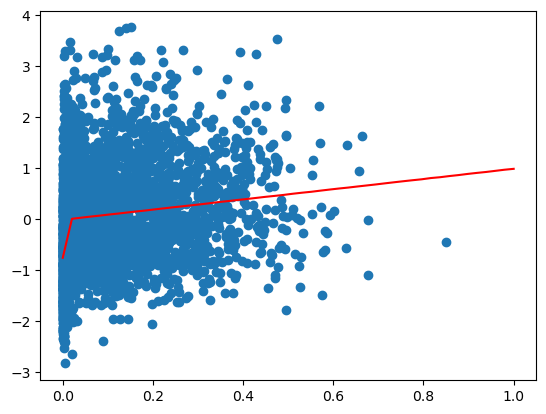

In [19]:
fig, ax = plt.subplots()
dh = np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0)))
mask = dh>.01
# ax.scatter(np.abs(dh[mask]),y_sm[:,:,mask].mean(axis=1))
ax.scatter(np.abs(dh[mask]),rho[mask])


# r,p = sp.stats.spearmanr(np.abs(dh[mask]), y_sm[:,:,mask].mean(axis=1).ravel())
r,p = sp.stats.spearmanr(np.abs(dh[mask]), rho[mask])
print(r,p)


outerring = pp.calculate_zscored_F('outer_ring', zscore=True, exp_detrend = True)
fig, ax = plt.subplots()
ax.scatter(np.abs(dh), outerring[-1,:,:].ravel())

r,p = sp.stats.spearmanr(np.abs(dh), outerring[-1,:,:].ravel())
print(r,p)

dhbins = np.linspace(0,1,num=50)
outerring_bins = np.digitize(outerring[-1,:,:].ravel(), dhbins)
outerring_dig = np.array([outerring[-1,:,outerring_bins==i].mean() for i in range(dhbins.shape[0]+1)])
print(outerring_dig)
ax.plot(dhbins, outerring_dig[:-1], color='red')

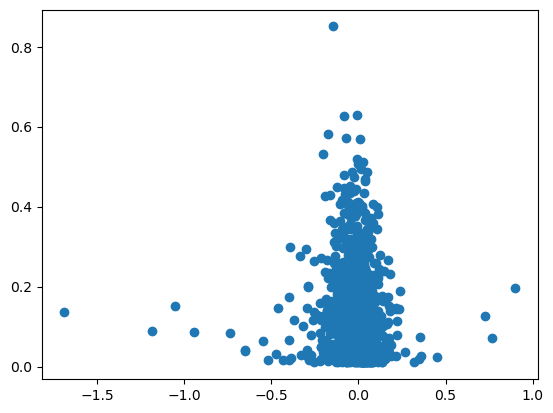

In [20]:
fig,ax = plt.subplots()
dphi= np.angle(np.exp(1j*np.ediff1d(phi, to_end=0)))
ax.scatter(dphi[mask], dh[mask])

# ax.scatter(heading[mask], phi[mask])

(array([417., 387., 410., 270., 127., 247., 594., 279., 263., 446.]),
 array([-3.14072456e+00, -2.51270994e+00, -1.88469533e+00, -1.25668071e+00,
        -6.28666099e-01, -6.51485398e-04,  6.27363129e-01,  1.25537774e+00,
         1.88339236e+00,  2.51140697e+00,  3.13942158e+00]),
 <BarContainer object of 10 artists>)

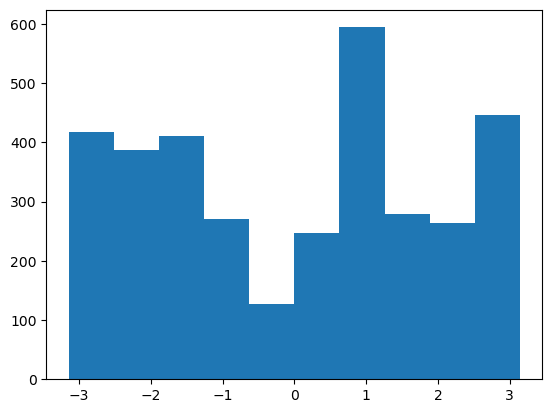

In [21]:
fig, ax = plt.subplots()
ax.hist(phi)